In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from tqdm import tqdm_notebook as tqdm
import itertools
import pickle

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import animation
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from IPython.core.display import display, HTML
from utils import *

bg_color = "#101010"
main_colors = ['#554DD2', '#C21D90', '#4ABDC2', "orange"]
sns.set_style("darkgrid", {"axes.facecolor": bg_color})
# plt.set_cmap("cool")
# plt.rcParams['font.size'] = 14
plt.style.use('dark_background')
mpl.rcParams['figure.facecolor'] = bg_color
mpl.rcParams['grid.color'] = 'w'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams['grid.linewidth'] = 0.5
plt.rcParams['font.size'] = 14
plt.rcParams['text.color'] = 'w'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print('Music data: a set of songs characteristics.')

df = pd.read_csv('music.csv', index_col='song.id')
print('Dataset length:', len(df))

_preprocess = False
if _preprocess:
    # Preprocessing
    df.columns = df.columns.map(lambda s: s.replace('.', '_'))
    df.loc[df['year'] == 0, 'year'] = np.nan
    for column in ['artist_name', 'title', 'release_name']:
        df.loc[df[column].isna(), column] = ''
    df['decade'] = 10 * (df.year // 10)
    df['duration_min'] = df.duration / 60
    df.artist_mbtags = df.artist_mbtags.apply(lambda t: shorten_tag(t))\
                    .apply(lambda t: t if t not in tags_inverse_mapping
                           else tags_inverse_mapping[t])
    
    df['title_tokenized'] = df.title.apply(lambda s: clean_tokens(tokenize_flatten(s)))
    df['title_tokenized_length'] = df.title_tokenized.apply(len)
    df['release_name_tokenized'] = df.release_name.apply(lambda s: clean_tokens(tokenize_flatten(s)))
    df['release_name_tokenized_length'] = df.release_name_tokenized.apply(len)
    
    # Cleaning
    df = df.drop(index=df[df.time_signature_confidence > 1].index)
    df = df.drop(index=df[df.key > 12].index)
    columns_to_check = ['title', 'year']
    for ind, g in tqdm(enumerate(df.groupby('artist_name'))):
        temp_df = g[1][columns_to_check]
        for i, (index, row) in enumerate(temp_df.iterrows()):
            title = row.title.upper()
            year = row.year
            for (index2, row2) in temp_df[i+1:].iterrows():
                if (
                    title == row2.title.upper() and 
                    year == row2.year
                ):
                    temp_df = temp_df.drop(index=index2)
                    df = df.drop(index=index2)
    df.to_csv('music_clean.csv')
else:
    df = pd.read_csv('music_clean.csv', index_col='song.id')

print('Dataset length after cleaning:', len(df))

# Columns to be analyzed
col = {}
col['artist'] = ['artist_hotttnesss', 'artist_id', 'artist_name', 'familiarity',
                 'artist_mbtags', 'similar']
col['song'] = ['title', 'year', 'release_name']
col['tech1'] = ['duration_min', 'tempo']
col['tech2'] = ['tatums_start', 'bars_start', 'beats_start', 'time_signature']
col['tech2_conf'] = ['tatums_confidence', 'beats_confidence', 'bars_confidence', 'time_signature_confidence']
col['tech3'] = ['mode', 'key']
col['tech3_conf'] = ['mode_confidence', 'key_confidence']
col['location'] = ['location', 'latitude', 'longitude']

print()
print('An example of the song:')
df.head(1).T

Music data: a set of songs characteristics.
Dataset length: 10000
Dataset length after cleaning: 9962

An example of the song:


song.id,SOMZWCG12A8C13C480
artist_hotttnesss,0.401998
artist_id,ARD7TVE1187B99BFB1
artist_name,Casual
artist_mbtags,NaN
artist_mbtags_count,0
bars_confidence,0.643
bars_start,0.58521
beats_confidence,0.834
beats_start,0.58521
duration,218.932


In [3]:
n_songs, n_albums, n_artists = get_songs_albums_artists(df)
print('{} artists, {} albums and {} songs. But...'.format(n_artists, n_albums, n_songs))
n_songs, n_albums, n_artists = get_songs_albums_artists(df[~df.year.isna()])
print('With known release year: {} artists, {} albums and {} songs.'.format(n_artists, n_albums, n_songs))
from_year, to_year = int(df.year.min()), int(df.year.max())
print('Data collected from {} till {} year.'.format(from_year, to_year))

3887 artists, 8089 albums and 9962 songs. But...
With known release year: 2092 artists, 3887 albums and 4643 songs.
Data collected from 1926 till 2010 year.


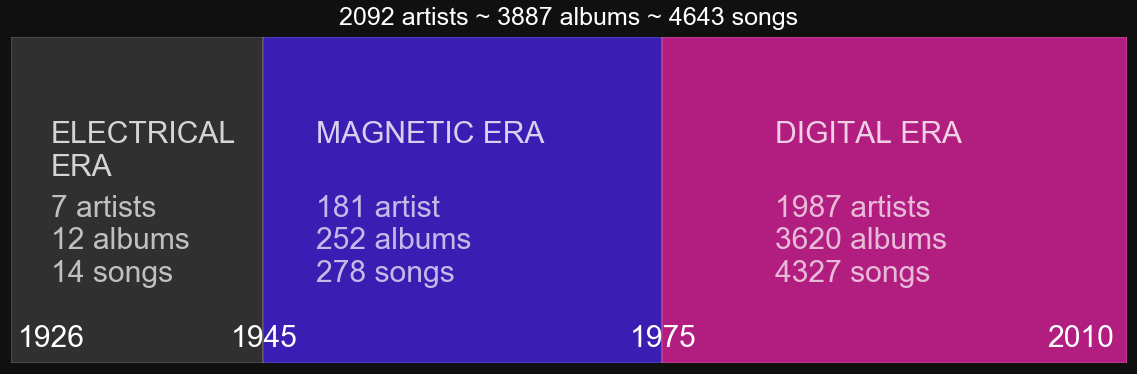

In [6]:
def create_main_vis():
    edge_el_year = 1945
    edge_magn_year = 1975

    df_dig = df[df.year > edge_magn_year]
    n_songs_dig = df_dig.shape[0]
    n_albums_dig = df_dig.release_id.nunique()
    n_artists_dig = df_dig.artist_id.nunique()

    df_magn = df[df.year < edge_magn_year]
    df_magn = df_magn[df_magn.year > edge_el_year]
    n_songs_magn, n_albums_magn, n_artists_magn = get_songs_albums_artists(df_magn)

    df_el = df[df.year < edge_el_year]
    n_songs_el, n_albums_el, n_artists_el = get_songs_albums_artists(df_el)

    mpl.rcParams['figure.figsize'] = (20,6)
    plt.barh(0, edge_el_year-from_year, height=2, left=from_year, color='#303030', linewidth=0.25)
    plt.barh(0, edge_magn_year-edge_el_year, height=2, left=edge_el_year, color='#3A1DB2', linewidth=0.25)
    plt.barh(0, to_year-edge_magn_year, height=2, left=edge_magn_year, color='#B21D80', linewidth=0.25)
    plt.yticks([])
    plt.xticks([])
    plt.ylim(-1, 1)
    plt.xlim(from_year, to_year)
    bottom = -0.9
    center = -0.5
    top = 0.35
    fontsize = 30
    fontsize2 = 30
    plt.annotate(from_year, [from_year+0.5, bottom], color='w', fontsize=fontsize)
    plt.annotate(edge_el_year, [edge_el_year-2.4, bottom], color='w', fontsize=fontsize)
    plt.annotate(edge_magn_year, [edge_magn_year-2.4, bottom], color='w', fontsize=fontsize)
    plt.annotate(to_year, [to_year-6, bottom], color='w', fontsize=fontsize)


    plt.annotate('Electrical\nEra'.upper(), [1929, top-0.2], color='w', fontsize=fontsize, alpha=0.8)
    plt.annotate('{} artists\n{} albums\n{} songs'.format(n_artists_el, n_albums_el, n_songs_el),
                 [1929, center], color='w', fontsize=fontsize2, alpha=0.7)

    plt.annotate('Magnetic Era'.upper(), [1949, top], color='w', fontsize=fontsize, alpha=0.8)
    plt.annotate('{} artist\n{} albums\n{} songs'.format(n_artists_magn, n_albums_magn, n_songs_magn),
                 [1949, center], color='w', fontsize=fontsize2, alpha=0.7)

    plt.annotate('Digital Era'.upper(), [1983.5, top], color='w', fontsize=fontsize, alpha=0.8)
    plt.annotate('{} artists\n{} albums\n{} songs'.format(n_artists_dig, n_albums_dig, n_songs_dig),
                 [1983.5, center], color='w', fontsize=fontsize2, alpha=0.7)
    plt.title('{} artists ~ {} albums ~ {} songs'.format(n_artists, n_albums, n_songs),
              fontsize=25, pad=12)
    
create_main_vis()
template_vis()
plt.savefig('vis_main.png', facecolor=bg_color)
plt.show()

# Artist

Зфокусуємо увагу на таких параметрах як `artist_hotttnesss`, `familiarity`, `artist_mbtags`, `similar`, що визначають популярність, стиль музики та схожих виконавців.

In [5]:
def get_df_artist():
    df_artist = df[col['artist']+['year']].drop_duplicates()
    artists_ids = []
    artists_names = []
    hotttnesses = []
    familiarities = []
    mbtags = []
    similars = []
    years = []
    for ind, g in tqdm(enumerate(df_artist.groupby('artist_id'))):
        artists_ids.append(g[0])
        artists_names.append(g[1].artist_name[0])
        hotttnesses.append(g[1].artist_hotttnesss.mean())
        familiarities.append(g[1].familiarity.mean())
        mbtags.append(g[1].artist_mbtags[0])
        similars.append(g[1].similar[0])
        years.append(np.nan if np.isnan(g[1].year.mean()) else int(round(g[1].year.mean())))

    df_artist = pd.DataFrame({'name': artists_names,
                              'hottness': hotttnesses,
                              'familiarity': familiarities,
                              'mbtags': mbtags,
                              'similar': similars,
                              'year': years},
                             index=artists_ids)
    df_artist['decade'] = 10 * (df_artist.year // 10)
    return df_artist

df_artist = get_df_artist()

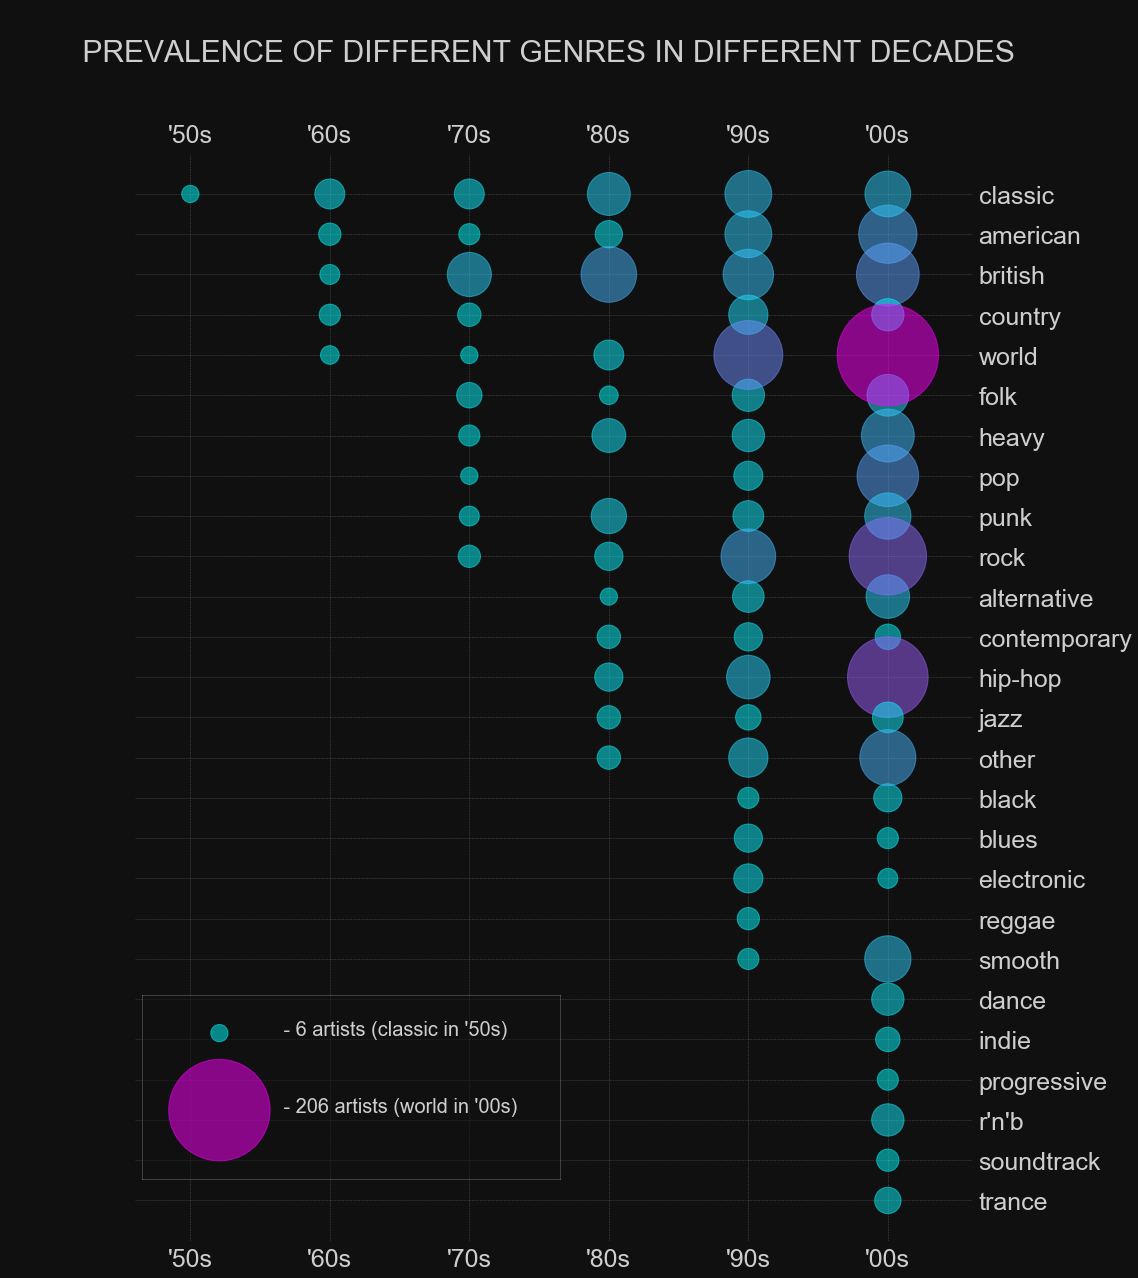

In [8]:
def create_genres_vis(min_freq=5, figsize=(15, 20)):
    xs, ys, sizes = [], [], []
    for g in list(df.groupby(['decade', 'artist_mbtags'])):
        s = len(g[1])
        if s > min_freq:
            xs.append(g[0][0])
            ys.append(g[0][1])
            sizes.append(50*s)
            
    mpl.rcParams['figure.figsize'] = figsize
    fig, parent_axes = plt.subplots()
    template_vis()
    plt.margins(0.04)
    plt.tick_params(top=True, bottom=True, labeltop=True, labelbottom=True,
                    right=True, labelright=True, left=False, labelleft=False)
    plt.gca().grid(which='major', alpha=0.25, linestyle='--')
    
    plt.scatter(xs, ys, s=sizes, c=sizes, cmap='cool', alpha=0.5)
    # Axis
    plt.yticks(fontsize=25, alpha=0.8)
    plt.xticks(np.arange(1940,2020,10), ['\'{:02}s'.format(i%100) for i in np.arange(1940,2020,10)],
               fontsize=25, alpha=0.8)
    plt.gca().xaxis.set_ticks_position('none') 
    plt.gca().yaxis.set_ticks_position('none') 
    plt.gca().invert_yaxis()
    
    # Frame
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.xlim(left=1946, right=2006)
    plt.title('\n         Prevalence of different genres in different decades'.upper(), x=0.45, y=1.08,
                 fontweight='normal', fontstretch='0', fontsize=30, alpha=0.8)
    
    ins_axes = inset_axes(parent_axes,
                    width="50%",
                    height="17%",
                    bbox_to_anchor=(0, 0.05, 1, 1),
                    bbox_transform=parent_axes.transAxes,
                    loc='lower left')

    ins_axes.scatter([0,0], ['world', 'classic'], s=[206*50,6*50],
                     c=[206*50,6*50], cmap='cool', alpha=0.5)
    ins_axes.grid(False)
    ins_axes.set_facecolor('#101010')
    ins_axes.patch.set_alpha(0.5)
    ins_axes.set_yticks([])
    ins_axes.set_xticks([])
    for spine in ins_axes.spines.values():
        spine.set_alpha(0.25)
    ins_axes.set_ylim([-0.9,1.5])
    ins_axes.set_xlim([-0.4,1.75])
    ins_axes.annotate(' - 6 artists (classic in \'50s)', (0.3,0.97), fontsize=20, alpha=0.8)
    ins_axes.annotate(' - 206 artists (world in \'00s)', (0.3,-0.02), fontsize=20, alpha=0.8)

create_genres_vis(min_freq=5, figsize=(15, 20))
plt.savefig('vis_genres.png', facecolor=bg_color)
plt.show()

Вище бачимо, як змінювався стиль музики за десятиліття, точніше, як він доповнювався. Пісень ставало все більше і більше, і все більше з'являлось нових жанрів. Окрім `world` music, що посіла перше місце за розповсюдженністю у 2000х, також популярним були `rock` і `hip-hop`.

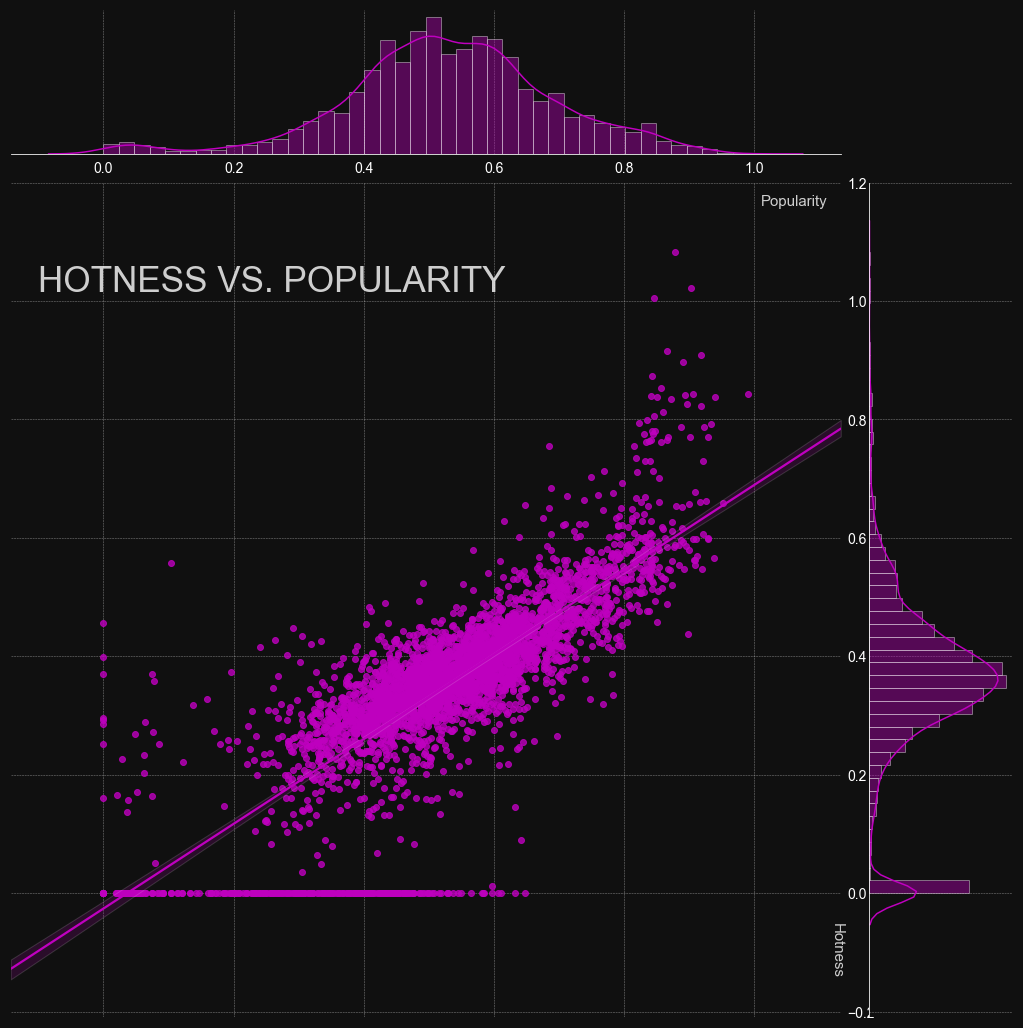

In [9]:
def create_popularity_vis(figsize = (15,15)):
    sns.set_style(rc={"axes.facecolor": bg_color})
    sns.jointplot("familiarity", "hottness", data=df_artist, kind="reg", color='m',
                  height=figsize[0], )
    plt_captions('', '', '', labelsize=20)
    plt.annotate('Popularity', (1.01,1.18),
            horizontalalignment='left', verticalalignment='top',
            fontsize=15, color='white', alpha=0.8, zorder=10)
    plt.annotate('Hotness', (1.115,-0.05), rotation=-90,
            horizontalalignment='left', verticalalignment='top',
            fontsize=15, color='white', alpha=0.8, zorder=10)

    plt.annotate('Hotness vs. Popularity'.upper(), (-0.1,1.06),
            horizontalalignment='left', verticalalignment='top',
            fontsize=35, color='white', alpha=0.8, zorder=10)
    plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False,
                    right=True, labelright=True, left=False, labelleft=False)
    template_vis()

create_popularity_vis(figsize = (15,15))
plt.savefig('vis_popularity.png', facecolor=bg_color)
plt.show()

Тут відслітковується кореляція між такими параметрами артиста як `popularity` та `hotness`.

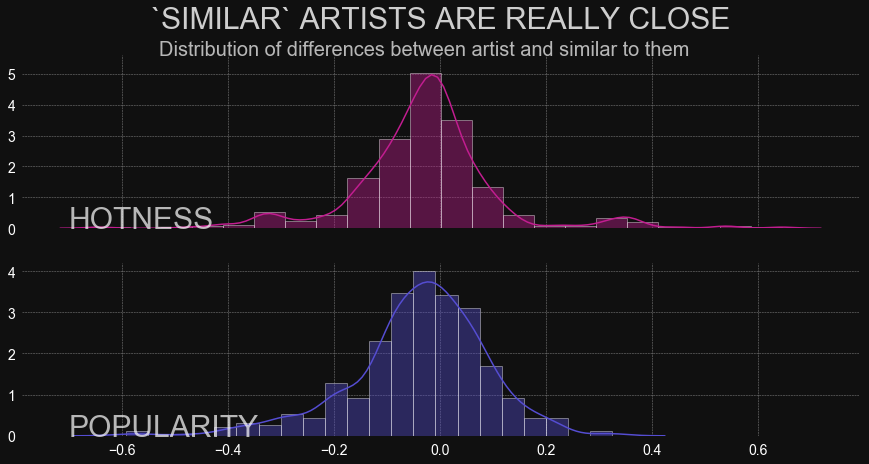

In [68]:
# artists, stds = [], []
# diffs = np.array([[0,0]])
# for artist1 in tqdm(df_artist.index):
#     artists2 = list(df_artist[df_artist.similar==artist1].index)
#     if len(artists2) > 1:
#         artists.append(artist1)
#         stds.append(np.array(df_artist.loc[list(artists2)+[artist1], ['hottness', 'familiarity']]).std(0))
#         diff = np.array(df_artist.loc[list(artists2), ['hottness', 'familiarity']]) -\
#               np.array(df_artist.loc[[artist1], ['hottness', 'familiarity']])
#         diffs = np.vstack((diffs, diff))
# diffs = diffs[1:]
# stds = np.array(stds)
    
def create_similar_vis(figsize=(15, 5)):
    mpl.rcParams['figure.figsize'] = figsize
    fig, axs = plt.subplots(2,1, sharex=True)
    plot_histogram(diffs[:,0], ax=axs[0])
    axs[0].set_title('`similar` artists are really close'.upper(),
                     fontweight='normal', fontstretch='0', fontsize=30, alpha=0.8, pad=27)
    axs[0].set_ylim(0,5.6)
    axs[0].annotate('Distribution of differences between artist and similar to them',
                    (-0.53,5.6), fontstretch='0', fontsize=20, alpha=0.7)
    axs[0].annotate('Hotness'.upper(), (-0.7,0), fontstretch='0', fontsize=30, alpha=0.7)
    template_vis()
    plot_histogram(diffs[:,1], ax=axs[1])
    axs[1].annotate('Popularity'.upper(), (-0.7,0), fontstretch='0', fontsize=30, alpha=0.7)
    template_vis()

create_similar_vis(figsize=(15, 7))
plt.savefig('vis_similar.png', dpi=150, facecolor=bg_color)
plt.show()

З графіку вище бачимо, що схожі артисти в основному близькі за популярністю (оскільки різниця близька до нуля).

# Song characteristics

Далі зфокусуємо увагу на таких харакатеристиках пісні як рік випуску, назва пісні та назва альбому:

Поглянемо, який розподіл кількості пісень за роками.

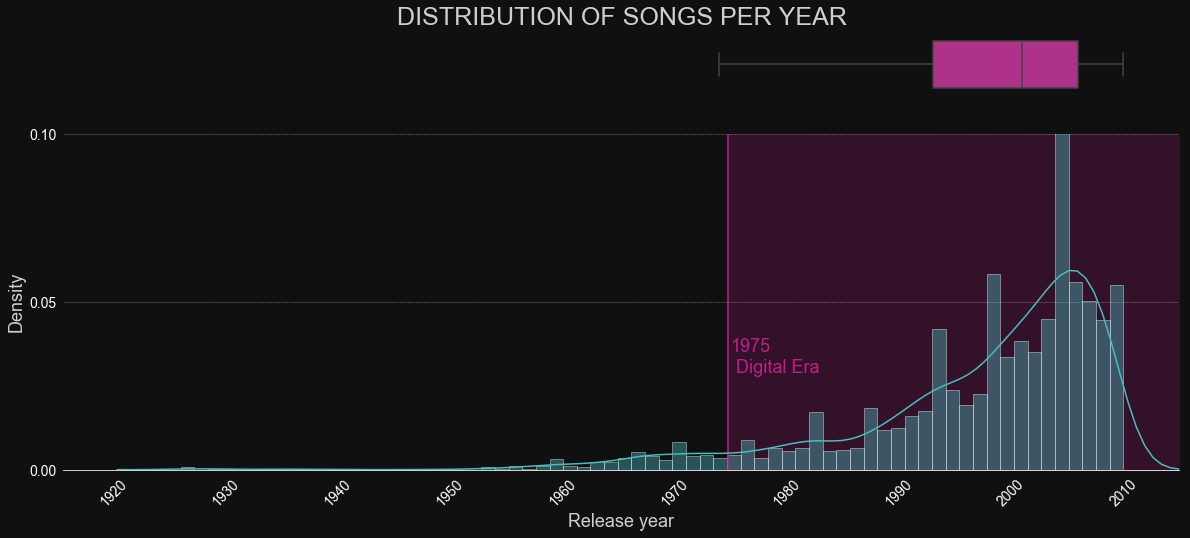

In [56]:
def create_songs_distr():
    represent_distribution(df.year.dropna(), kind='01', norm_hist=True, figsize=(20,8),
                           title='Distribution of songs per year'.upper(), titlesize=25)
    plt.yticks([0,0.05,0.1])
    plt.xticks(np.arange(1920,2020,10), rotation=45) #[1930,1940,1960,1970, 1990,2000]
    plt_captions('', 'Release year', 'Density')
    cl = '#C21D90'
    plt.annotate('1975\n Digital Era', [1975, 0.029], fontsize=18, color=cl, alpha=1)
    plt.fill_between([1974.8,2016], [0,0], [0.105,0.105], color=cl, alpha=0.2, zorder=0)
    plt.vlines(1974.8, 0, 0.1, cl)
    plt.ylim(top=0.1)
    plt.xlim(right=2015)
    template_vis()
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().xaxis.grid(False)

create_songs_distr()
plt.savefig('vis_song_distr.png', dpi=150, facecolor=bg_color)
plt.show()

Отже, більша частина припадає на 1970 - 2010 рік. Якраз у 1975 починається цифрова ера, тому не дивно.

Дослідимо, яка зазвичай довжина назви пісень та альбомів, а також найчастшіші назви.

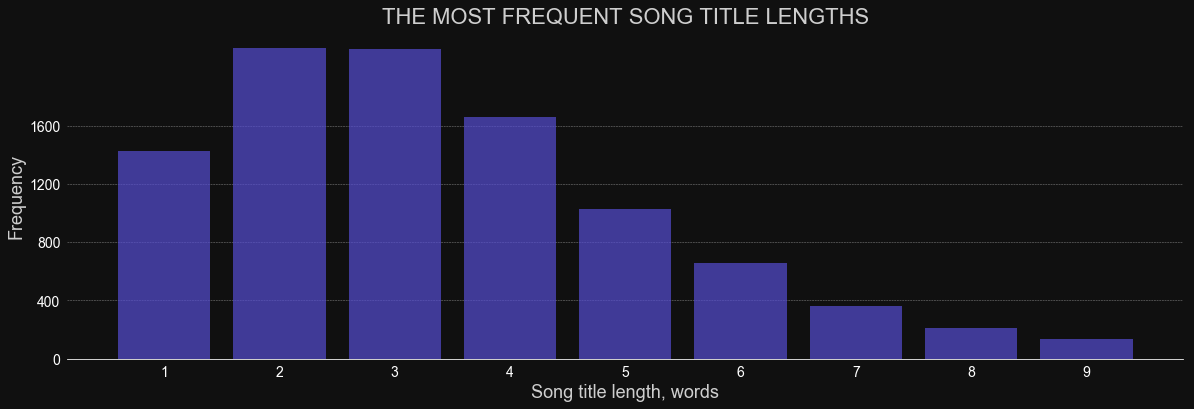

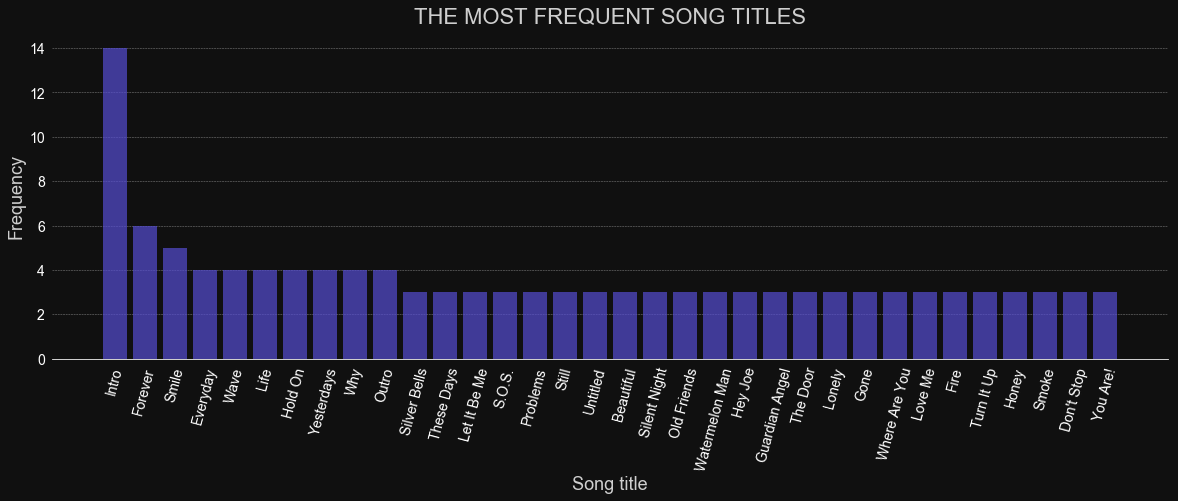

In [27]:
def create_freq_vis(by, aux, series, min_freq_to_show, title='', xlabel='', ylabel=''):
    frequency(df, by, aux, series, min_freq_to_show=min_freq_to_show)
    plt_captions(title, xlabel, ylabel)
    template_vis()
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().xaxis.grid(False)


create_freq_vis('title_tokenized_length', None, None, 100,
                'The most frequent song title lengths', 'Song title length, words', 'Frequency')
plt.yticks(np.arange(0,1800,400))
plt.xticks(np.arange(1,10))
plt.savefig('vis_freq_song_title_lengths.png', facecolor=bg_color)
plt.show()
create_freq_vis('title', None, None, 2,
                'The most frequent song titles', 'Song title', 'Frequency')
plt.yticks(np.arange(0,15,2))
plt.xticks(rotation=75)
plt.savefig('vis_freq_song_title.png', facecolor=bg_color)
plt.show()

Як видно зі статистики, серед назв пісень найчастіше (14 разів) в даних зустрічається назва `Intro` -- досить загальна назва, тому недивно. Також бачимо `Outro`; `Life`, `Forever`, `Smile` та інші загальні назви.

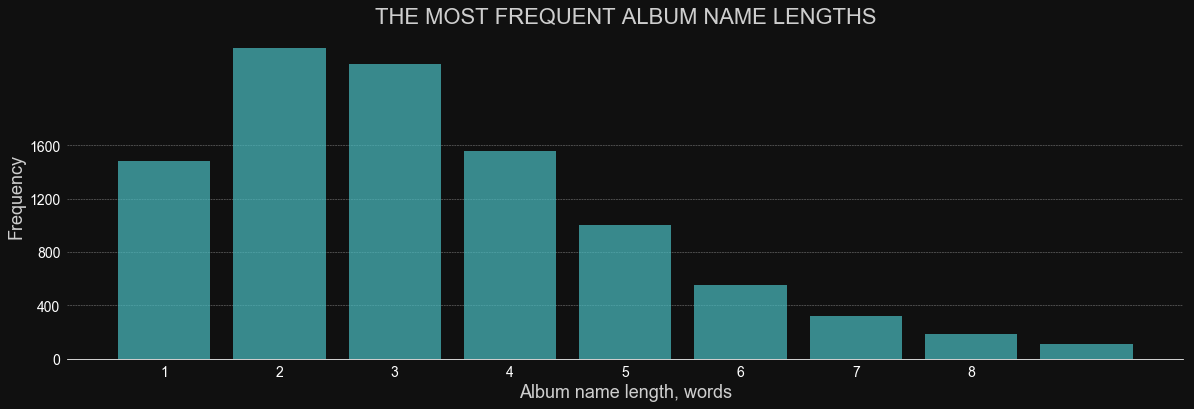

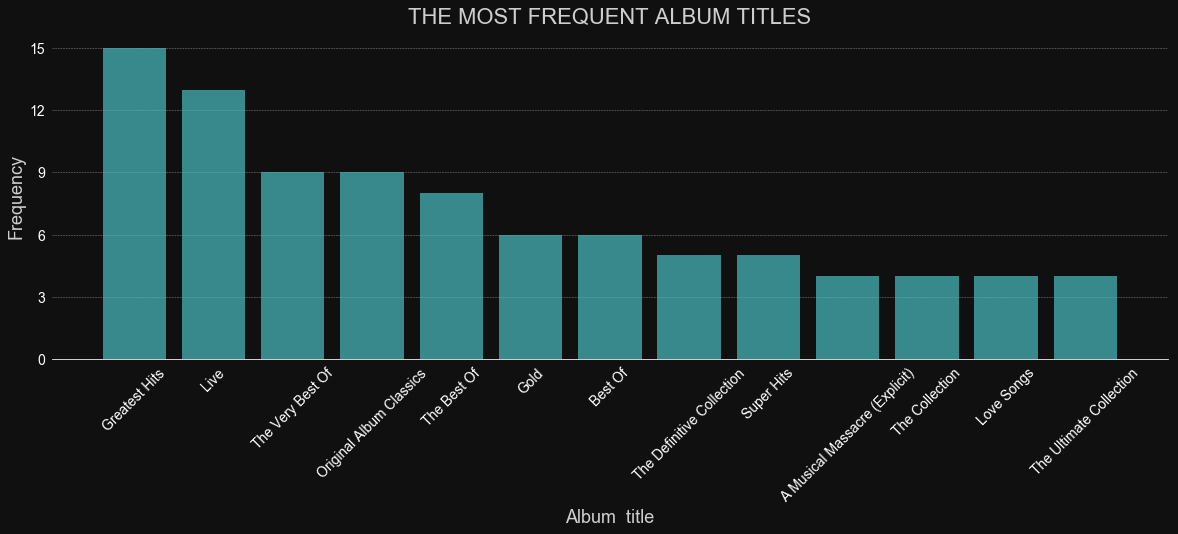

In [271]:
create_freq_vis('release_name_tokenized_length', None, None, 100,
                'The most frequent album name lengths', 'Album name length, words', 'Frequency')
plt.yticks(np.arange(0,1800,400))
plt.xticks(np.arange(1,9))
plt.savefig('vis_freq_album_title_lengths.png', facecolor=bg_color)
plt.show()

create_freq_vis('release_name', 'artist_name', None, 3,
                'The most frequent album titles', 'Album  title', 'Frequency')
plt.yticks(np.arange(0,18,3))
plt.xticks(rotation=45)
plt.savefig('vis_freq_album_title.png', facecolor=bg_color)
plt.show()

Тут можна помітити серед альбомів, які співпадають за назвою, в основном збірники пісень різних виконавців типу `Greatest Hits`, `The Best Of` і т.д. тобто назви оригінальні альбомів (на відміну від пісень) унікальні.

Подивимось, які слова в принципі найчастіше зучтрічаються в назвах пісень:

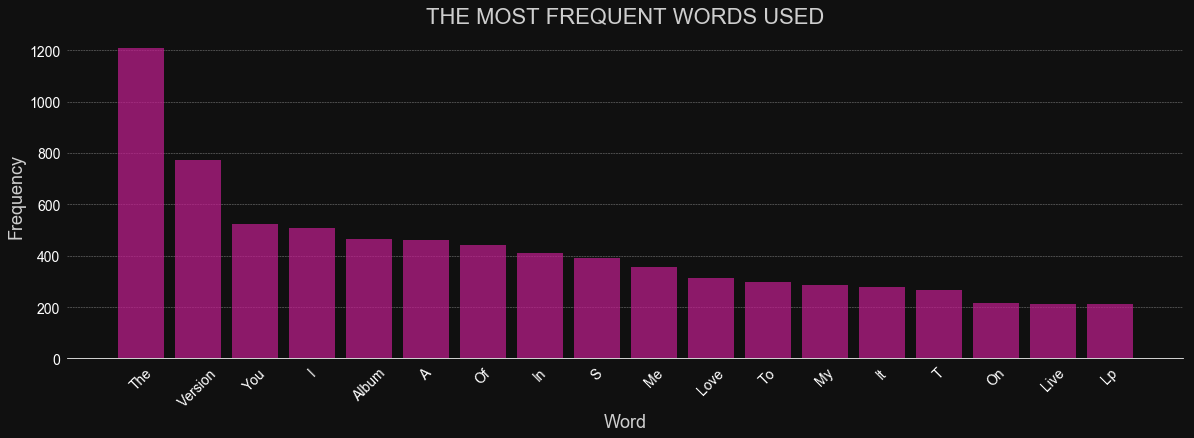

In [40]:
df['title_tokenized'] = df.title.apply(lambda s: clean_tokens(tokenize_flatten(s)))
df['title_tokenized_length'] = df.title_tokenized.apply(len)
df['release_name_tokenized'] = df.release_name.apply(lambda s: clean_tokens(tokenize_flatten(s)))
df['release_name_tokenized_length'] = df.release_name_tokenized.apply(len)

title_words = list(itertools.chain(*[set(s) for s in df['title_tokenized'].values]))
title_words = Series(list(map(lambda s: s.capitalize(), title_words)))
create_freq_vis(None, None, title_words, 200,
                'The most frequent words used', 'Word', 'Frequency')
plt.xticks(rotation=45)
plt.savefig('vis_freq_song_title_words.png', facecolor=bg_color)
plt.show()

Багато слів, що не несуть особливого сенсу (займенники, артиклі тощо). Тому приберемо їх.

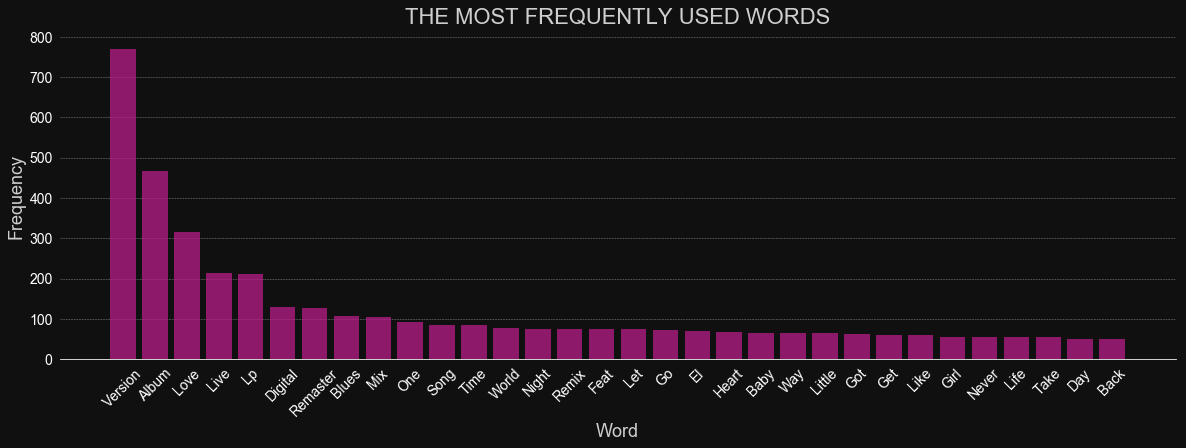

In [42]:
_load_title_words_without_stopwords = True

if _load_title_words_without_stopwords:
    with open('title_words_without_stopwords.pkl', 'rb') as f:
        title_words_without_stopwords = pickle.load(f)
else:
    title_words_without_stopwords = Series(remove_stopwords(title_words, [u'english',
                                                              u'italian',
                                                              u'german',
                                                              u'dutch',
                                                              u'portuguese',
                                                              u'french']))
    with open('title_words_without_stopwords.pkl', 'wb') as f:
        pickle.dump(title_words_without_stopwords, f)

create_freq_vis(None, None, title_words_without_stopwords, 50,
                'The most frequently used words', 'Word', 'Frequency')
plt.xticks(rotation=45)
plt.savefig('vis_freq_song_title_words.png', facecolor=bg_color)
plt.show()

Тож, не звертаючи уваги на `Version`, `Album` і тд, найчастіше слово `Love`. Напевне, частіше за все люди співають про кохання. Також багато `Blues`, `Mix`, `Remix`, що визначають стиль музики. Ще можемо помітити, що часто співають про час, світ, ніч, життя та дітей :))) Ймовірно, про дівчат співають більше, ніж про хлопців.

Аналіз текстів досить поверхневий, для більших інсайтів тут можна було б застосувати методи Natural Language Processing для знаходження, наприклад, кластерів назв за близкістю, але це виходить за рамки курсу.

## Technical

Подивимось, як з часом змінювались різні технічні характеристики музики.

In [80]:
def create_stripplots(columns, title='', ylabels=None,
                      yxticks=None, yxticks_labels=None,
                      figsize=(15,6)):
    if ylabels is None:
        ylabels = columns
    mpl.rcParams['figure.figsize'] = (figsize[0],figsize[1]*len(columns))
    for i in range(len(columns)):
        plt.subplot(len(columns),1,i+1)
        if i == 0:
            plt.title(title, fontsize=25, alpha=0.8)
        ax = sns.violinplot(x="decade", y=columns[i], data=df, inner=None,
                            color="w", linewidth=0)
        plt.setp(ax.collections, alpha=0.1)
        sns.stripplot(x="decade", y=columns[i], alpha=0.5,
                      data=df, jitter=True, palette="cool")
        template_vis()
        plt.xticks(np.arange(10), labels=['\'{:02}s'.format(i%100) for i in np.arange(1920,2020,10)])
        if yxticks is not None:
            plt.yticks(yxticks[i], yxticks_labels[i])
        plt.xlabel('')
        plt.ylabel(ylabels[i])
#     plt.xlabel('Decade')

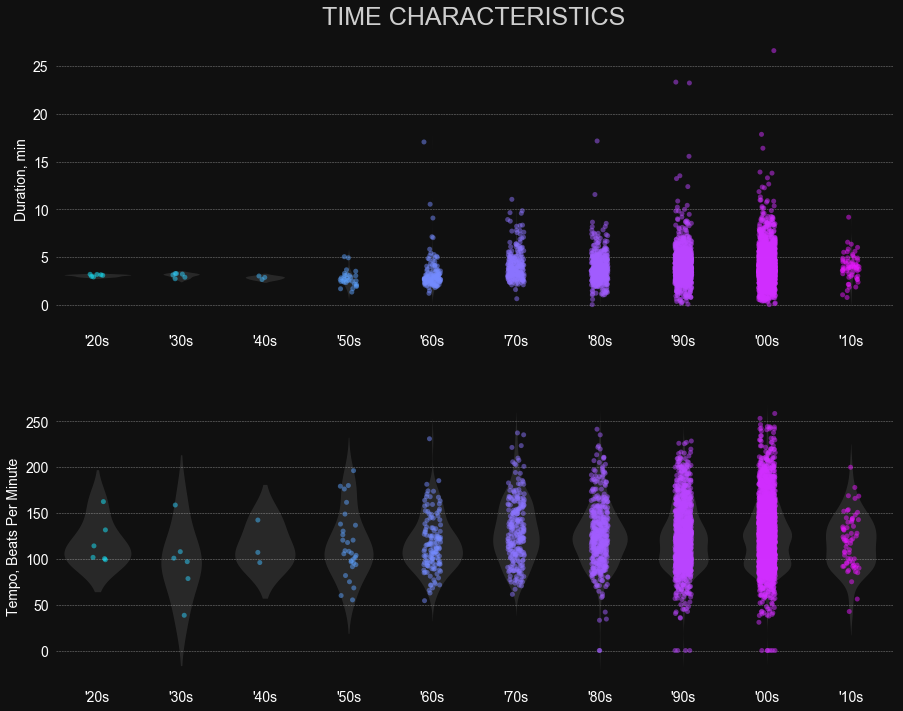

In [81]:
create_stripplots(col['tech1'], title='Time characteristics'.upper(),
                 ylabels = ['Duration, min', 'Tempo, Beats Per Minute '])
plt.savefig('vis_time.png', dpi=150, facecolor=bg_color)
plt.show()

В розподілі довжини пісні збільшивлись межі до 25+ хвилин; так само розширив межі темп.

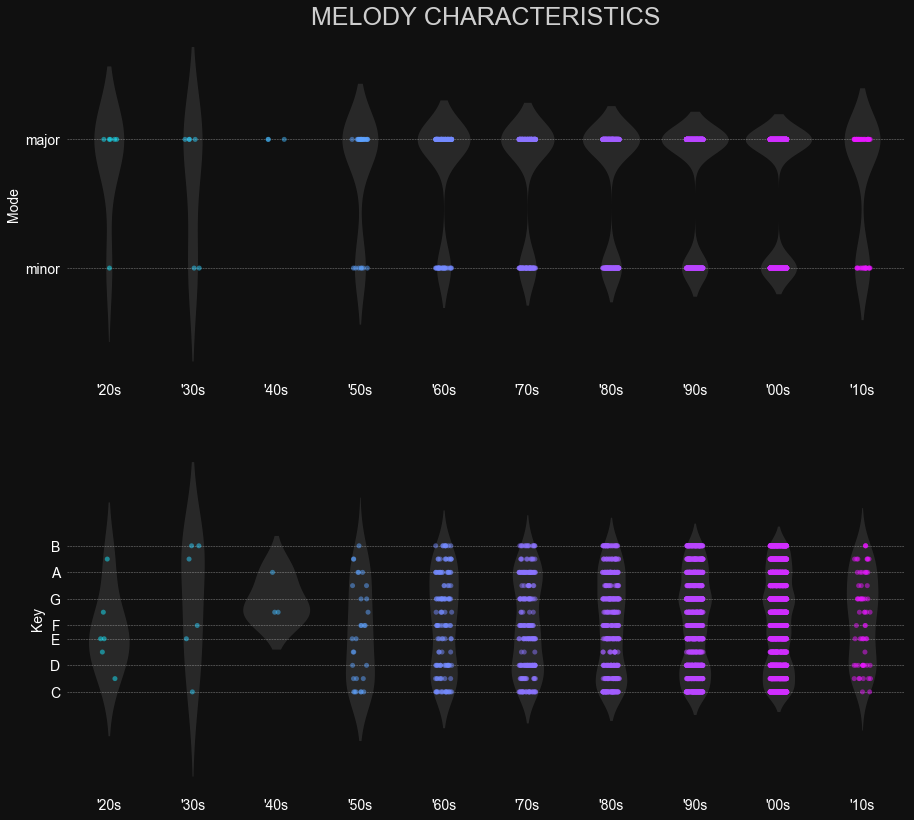

In [82]:
modes = [0, 1]
modes_labels = ['minor', 'major']
# keys = np.arange(12)
# keys_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
keys = [0,2,4,5,7,9,11]
keys_labels = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
yxticks = [modes, keys]
yxticks_labels = [modes_labels, keys_labels]
create_stripplots(col['tech3'], title='Melody characteristics'.upper(), 
                  ylabels=['Mode', 'Key'],
                  yxticks=yxticks, yxticks_labels=yxticks_labels, figsize=(15,7))
plt.savefig('vis_melody.png', dpi=150, facecolor=bg_color)
plt.show()

В цілому, за виключенням 20х-40х (в яких замало даних) лад та ключ розподілені рівномірно. 

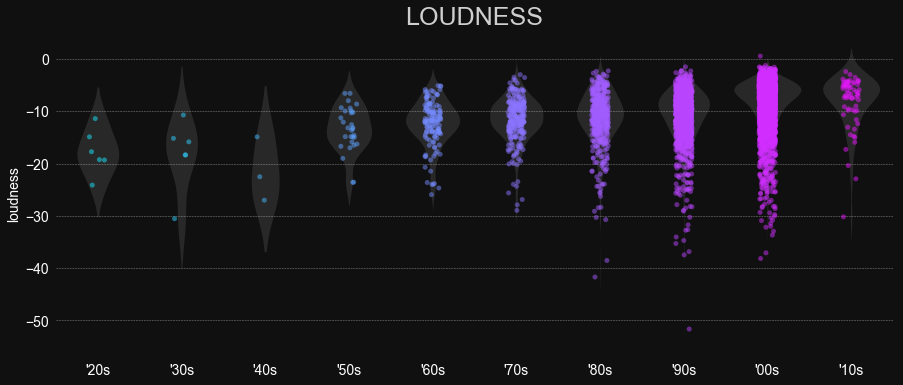

In [83]:
create_stripplots(['loudness'], title='Loudness'.upper())
plt.savefig('vis_loudness.png', dpi=150, facecolor=bg_color)

Бачимо, що гучність з десятиліттями збільшувалась. Для наглядності створимо анімацію:

MovieWriter imagemagick unavailable. Trying to use pillow instead.


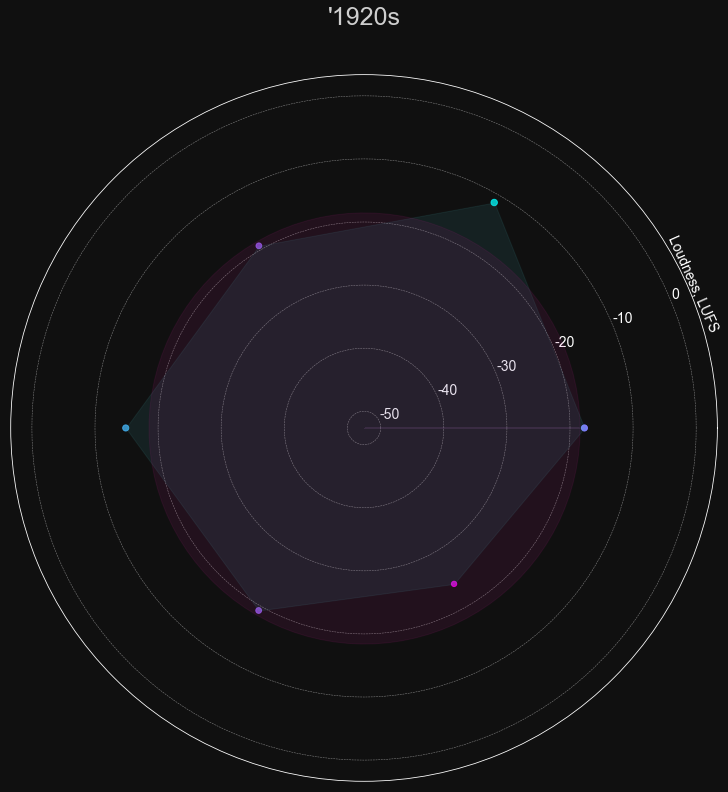

In [47]:
def create_loudness_vis(col='loudness', figsize=(13,13)):
    min_len = 5
    decades = []
    loudnesses = []
    lmedians = []
    for g in df[['decade', col]].dropna().groupby('decade'):
        l = list(g[1][col])
        if len(l) > min_len:
            decades.append(g[0])
            loudnesses.append(l)
            lmedians.append(np.median(l))

    lmin = df.loudness.min()
    axislimmax = df.loudness.max() - lmin + 1
    lmedians = lmedians - lmin + 1

    mpl.rcParams['figure.figsize'] = figsize

    def update_plot(i, decades, loudnesses, lmedians):
        l = loudnesses[i]
        N = len(l)
        r = l - lmin + 1
        theta = 2 * np.pi * np.arange(N) / N
        theta, r = list(theta), list(r)
        theta.append(theta[0])
        r.append(r[0])
        area = r
        colors = -np.array(r)#l.mean() * np.ones(N)

        ax.clear()
        ax.scatter(theta, r, c=colors, s=area, cmap='cool', alpha=0.75, zorder=3)
        ax.fill_between(np.linspace(0.0, 2*np.pi,100), lmedians[i] * np.ones(100),
                        color=main_colors[1], alpha=0.1, zorder=20, linewidth=1)
        ax.fill_between(theta, np.zeros_like(r), r,
                        alpha=0.1, color=main_colors[2], zorder=10)#, color=colors)#, s=area,, alpha=0.75)
        ax.set_ylim(top=56)
        yticks = np.arange(0,60,10) + 2.643
        ax.set_yticks(yticks)
        ax.set_yticklabels((yticks + lmin - 1).astype(np.int))
        ax.annotate('Loudness, LUFS', (0.55,56), rotation=-66)
        ax.set_title('\'{:02}s'.format(int(decades[i])), fontsize=25, alpha=0.8, pad=15)
        ax.set_facecolor("#101010")
        ax.set_xticks([])

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='polar')
    ax.set_ylim(top=axislimmax)
    ani = animation.FuncAnimation(fig, update_plot, len(decades)-1, fargs=(decades, loudnesses, lmedians))
    return ani

ani = create_loudness_vis('loudness', figsize=(13,13))
ani.save('vis_loudness.gif', writer='imagemagick', fps=4)
display(HTML(ani.to_html5_video()))

# Location

Наостанок подивимось на розподіл пісень за країнами

In [49]:
import plotly
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import reverse_geocoder as rg
import pycountry

def list_to_dict(countries):
    countries_dict = {}
    for cc in countries:
        if cc in countries_dict:
            countries_dict[cc] += 1
        else:
            countries_dict[cc] = 1
    return countries_dict

coordinates = [tuple(x) for x in list(np.array(df[['latitude','longitude']]))]
results = rg.search(coordinates)
countries_dict2 = list_to_dict([result['cc'] for result in results])

codes, names, values = [], [], []
for iso2 in countries_dict2:
    country = pycountry.countries.get(alpha_2=iso2)
    if country.alpha_3!='BMU':
        codes.append(country.alpha_3)
        names.append(country.name)
        values.append(np.log10(countries_dict2[iso2]))

scl = [
    [0.0, main_colors[2]],
    [0.5, main_colors[0]],
    [1.0, main_colors[1]]
]

data = [go.Choropleth(
    colorscale = scl,
    autocolorscale = False,
    locations = codes,
    z =  values,
    locationmode = 'ISO-3',
    text = names,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = '#101010',
            width = 1
        )),
    colorbar = go.choropleth.ColorBar(title = "# songs\n(log10 scale)"))
]

layout = go.Layout(
#     paper_bgcolor='#101010',
#     plot_bgcolor='#101010',
    title = go.layout.Title(
        text = 'Song Distibution by Country'
    ),
    geo = go.layout.Geo(
        showlakes = True,
#         projection = dict(type = 'orthographic'),
        lakecolor = '#101010'),
)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename='Map')

Loading formatted geocoded file...


Отже, за даними найбільша концентрація пісень в США. Далі йде Великобританія, Канада, Франція.